In [47]:
import pandas as pd
import numpy as np

import plotly.express as px

pd.set_option('Display.max_columns', None)

In [138]:
df = pd.read_csv('../data/games.csv', index_col=0)

# Force date into correct format
df['Date'] = pd.to_datetime(df['Date'])

# Make it capture both sides
chosen_columns_H = [col for col in df.columns if (col[0]=='H')]
chosen_columns_A = [col for col in df.columns if (col[0]=='A')]
switch_places_dict = {col:col.replace('H', 'A', 1) for col in chosen_columns_H} | {col:col.replace('A', 'H', 1) for col in chosen_columns_A} | {'OddsH': 'OddsA', 'OddsA': 'OddsH'}
df = pd.concat(
    [
        df,
        df.rename(switch_places_dict, axis=1)
    ]
).copy()

# Add result column
df['Result'] = np.where(
    df['HSC']>df['ASC'],
    1,
    0
)

# Add difference in scores
df['DSC'] = df['HSC'] - df['ASC']

# Add shooting accuracy
df['SHACC'] = df['HFGM'] / df['HFGA']

# Add 3 points accuracy
df['3PACC'] = df['HFG3M'] / df['HFG3A']

# Add attacking focus (offensive rebounds vs defensive rebounds)
df['ATFOC'] = df['HORB'] - df['HDRB']

df = df.sort_values(by='Date').reset_index(drop=True)
df['Index'] = list(df.index)
df.head()

,Season,Date,HID,AID,N,POFF,Open,OddsH,OddsA,H,A,HSC,ASC,HFGM,AFGM,HFGA,AFGA,HFG3M,AFG3M,HFG3A,AFG3A,HFTM,AFTM,HFTA,AFTA,HORB,AORB,HDRB,ADRB,HRB,ARB,HAST,AAST,HSTL,ASTL,HBLK,ABLK,HTOV,ATOV,HPF,APF,Result,DSC,SHACC,3PACC,ATFOC,Index
0,1,1975-11-07,13,28,0,0,1975-11-06,1.196537,4.833232,1,0,108,104,43.0,39.0,84.0,83.0,2.0,0.0,3.0,3.0,20.0,26.0,30.0,35.0,18.0,14.0,30.0,21.0,48.0,35.0,26.0,26.0,7.0,14.0,5.0,4.0,25.0,14.0,27.0,26.0,1,4,0.511905,0.666667,-12.0,0
1,1,1975-11-07,8,43,0,0,1975-11-06,2.536599,1.502570,0,1,123,127,49.0,49.0,99.0,92.0,1.0,0.0,6.0,0.0,24.0,29.0,31.0,36.0,18.0,14.0,27.0,36.0,45.0,50.0,26.0,29.0,15.0,9.0,3.0,10.0,18.0,23.0,31.0,19.0,0,-4,0.494949,0.166667,-9.0,1
2,1,1975-11-07,4,33,0,0,1975-11-06,3.778120,1.275743,0,1,104,134,43.0,55.0,93.0,102.0,2.0,1.0,6.0,2.0,16.0,23.0,24.0,26.0,16.0,19.0,18.0,35.0,34.0,54.0,27.0,36.0,7.0,9.0,4.0,7.0,17.0,13.0,22.0,18.0,0,-30,0.462366,0.333333,-2.0,2
3,1,1975-11-07,34,41,0,0,1975-11-06,7.379109,1.112895,0,1,102,120,37.0,47.0,85.0,84.0,0.0,1.0,1.0,4.0,28.0,25.0,36.0,25.0,20.0,14.0,18.0,30.0,38.0,44.0,18.0,31.0,10.0,5.0,6.0,6.0,22.0,18.0,25.0,27.0,0,-18,0.435294,0.000000,2.0,3
4,1,1975-11-07,2,24,0,0,1975-11-06,2.871500,1.412886,1,0,127,110,53.0,39.0,86.0,77.0,1.0,0.0,3.0,4.0,20.0,32.0,24.0,37.0,13.0,9.0,24.0,16.0,37.0,25.0,31.0,28.0,10.0,8.0,4.0,4.0,23.0,20.0,32.0,27.0,1,17,0.616279,0.333333,-11.0,4


In [139]:
start_index = df.loc[
    df['Date']==df.loc[df['Season']==2]['Date'].min()
].index.min()
min_date_team_season = df.groupby(['Season', 'HID'])['Date'].min().to_dict()
features_columns = [
    'f_DSC', # Difference in scores,
    'f_SHACC', # Shooting accuracy
    'f_3PACC', # 3 points accuracy
    'f_OFREB', # Offensive rebounds
    'f_OFRAP', # Offensive rebounds against opponent
    'f_DFREB', # Defensive rebounds
    'f_DFRAP', # Defensive rebounds against opponent
    'f_ATFOC', # Attacking focus (offensive rebounds vs defensive rebounds)
    'f_OPASC', # Opponent score
    'f_BLOCC', # Blocks
    'f_TURNV', # Turnovers
]
for feature in features_columns:
    for window in (3, 10):
        df[feature+str(window)] = [None] * df.shape[0]

for feature in features_columns:
    df[feature+'_delta'] = df[feature+'3'] - df[feature+'10']

for index in df.index[list(df.index).index(start_index):]:
    season = df.at[index, 'Season']
    team_id = df.at[index, 'HID']
    date = df.at[index, 'Date']
    print('Date:', date)

    # If this is the first match of the season:
    # min_date = min_date_team_season.get((season, team_id), None)
    # if min_date and min_date==date:
    #     pass
    # else:
    df_team = df.loc[
        (df['HID']==team_id) & (df['Index']<index)
    ].copy()

    for window in (3, 10):
        df_team_selected = df_team.tail(window)
        df.at[index, f'f_DSC{window}'] = df_team_selected['DSC'].mean()
        df.at[index, f'f_SHACC{window}'] = df_team_selected['SHACC'].mean()
        df.at[index, f'f_3PACC{window}'] = df_team_selected['3PACC'].mean()
        df.at[index, f'f_OFREB{window}'] = df_team_selected['HORB'].mean()
        df.at[index, f'f_OFRAP{window}'] = np.mean(
            df_team_selected['HORB'] - df_team_selected['AORB']
        )
        df.at[index, f'f_DFREB{window}'] = df_team_selected['HDRB'].mean()
        df.at[index, f'f_DFRAP{window}'] = np.mean(
            df_team_selected['HDRB'] - df_team_selected['ADRB']
        )
        df.at[index, f'f_ATFOC{window}'] = df_team_selected['ATFOC'].mean()
        df.at[index, f'f_OPASC{window}'] = df_team_selected['ASC'].mean()
        df.at[index, f'f_BLOCC{window}'] = df_team_selected['HDRB'].mean()
        df.at[index, f'f_TURNV{window}'] = df_team_selected['HSTL'].mean()
    
    for feature in features_columns:
        df.at[index, f'{feature}_delta'] = df.at[index, f'{feature}3'] - df.at[index, f'{feature}10']

Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-12 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-11-13 00:00:00
Date: 1976-1

In [141]:
df.to_csv('06_additional_features.csv')

/tmp/ipykernel_1430092/608267921.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  selected_data = selected_data.replace(np.nan, 0)


              precision    recall  f1-score   support

           0       0.59      0.58      0.59     27976
           1       0.59      0.60      0.60     27976

    accuracy                           0.59     55952
   macro avg       0.59      0.59      0.59     55952
weighted avg       0.59      0.59      0.59     55952



/home/main/Documents/GitHub/qminers-24/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


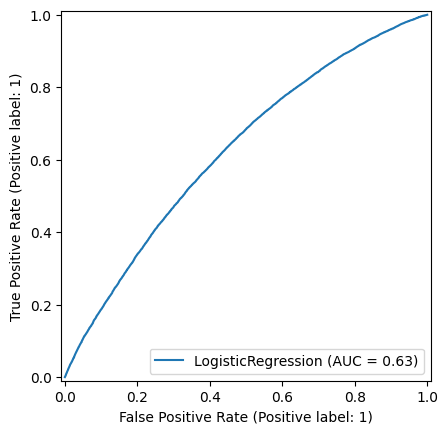

In [168]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

selected_columns = [col for col in df.columns if col[0]=='f'] + ['Result']
selected_data = df.loc[
    df['Season']>1
][selected_columns].copy()
selected_data = selected_data.replace(np.nan, 0)

X = selected_data
y = selected_data.pop('Result')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

logreg = LogisticRegression()
logreg.fit(X, y)

y_pred1 = logreg.predict(X)

print(classification_report(y, y_pred1))

RocCurveDisplay.from_estimator(
    logreg, X, y
)

              precision    recall  f1-score   support

       False       0.69      0.69      0.69     27976
        True       0.69      0.69      0.69     27976

    accuracy                           0.69     55952
   macro avg       0.69      0.69      0.69     55952
weighted avg       0.69      0.69      0.69     55952



/home/main/Documents/GitHub/qminers-24/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


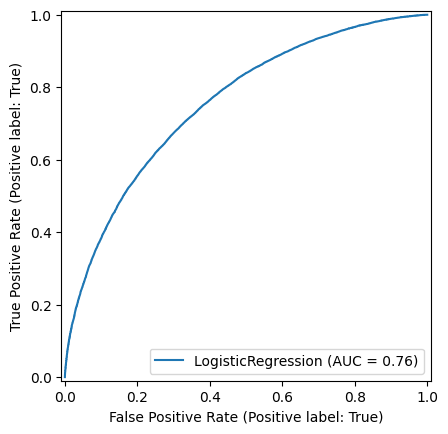

In [173]:
data = df.loc[df['Season']>1].copy()
data = data[['OddsH', 'OddsA', 'HSC', 'ASC']].copy()
data['Result'] = data['HSC'] > data['ASC']
data['OddsDiff'] = data['OddsH'] - data['OddsA']
data.pop('HSC')
data.pop('ASC')

X = data
y = data.pop('Result')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

logreg = LogisticRegression()
logreg.fit(scaled_data, y)

y_pred2 = logreg.predict(scaled_data)

print(classification_report(y, y_pred2))

RocCurveDisplay.from_estimator(
    logreg, X, y
)

In [178]:
matrix_df = pd.DataFrame(
    {'Preds': [bool(val) for val in y_pred1], 'Odds': y_pred2, 'Actual': y}
)
confusion_matrix = pd.crosstab(
    [matrix_df['Preds'], matrix_df['Odds']], matrix_df['Actual'], rownames=['My prediction', 'Odds prediction'], colnames=['Actual']
)
print(confusion_matrix)

Actual                         False  True 
My prediction Odds prediction              
False         False            12887   5164
              True              3436   6026
True          False             6319   3606
              True              5334  13180


/tmp/ipykernel_1430092/939572484.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  selected_data = selected_data.replace(np.nan, 0)


              precision    recall  f1-score   support

           0       0.69      0.69      0.69     27976
           1       0.69      0.69      0.69     27976

    accuracy                           0.69     55952
   macro avg       0.69      0.69      0.69     55952
weighted avg       0.69      0.69      0.69     55952



/home/main/Documents/GitHub/qminers-24/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


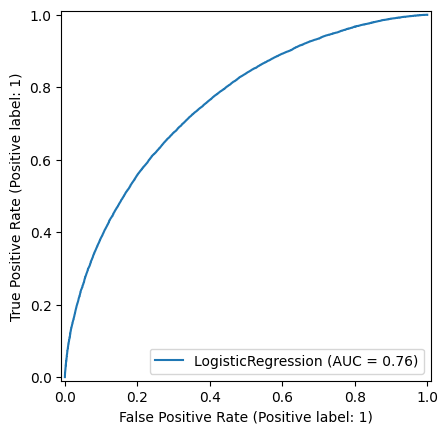

In [179]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

selected_columns = [col for col in df.columns if col[0]=='f'] + ['Result', 'OddsH', 'OddsA']
selected_data = df.loc[
    df['Season']>1
][selected_columns].copy()
selected_data = selected_data.replace(np.nan, 0)

X = selected_data
y = selected_data.pop('Result')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

logreg = LogisticRegression()
logreg.fit(X, y)

y_pred3 = logreg.predict(X)

print(classification_report(y, y_pred3))

RocCurveDisplay.from_estimator(
    logreg, X, y
)

In [180]:
matrix_df = pd.DataFrame(
    {'Preds': [bool(val) for val in y_pred3], 'Odds': y_pred2, 'Actual': y}
)
confusion_matrix = pd.crosstab(
    [matrix_df['Preds'], matrix_df['Odds']], matrix_df['Actual'], rownames=['My prediction', 'Odds prediction'], colnames=['Actual']
)
print(confusion_matrix)

Actual                             0      1
My prediction Odds prediction              
False         False            18833   8371
              True               353    335
True          False              373    399
              True              8417  18871


In [184]:
X.columns

Index(['f_DSC3', 'f_DSC10', 'f_SHACC3', 'f_SHACC10', 'f_3PACC3', 'f_3PACC10',
       'f_OFREB3', 'f_OFREB10', 'f_OFRAP3', 'f_OFRAP10', 'f_DFREB3',
       'f_DFREB10', 'f_DFRAP3', 'f_DFRAP10', 'f_ATFOC3', 'f_ATFOC10',
       'f_OPASC3', 'f_OPASC10', 'f_BLOCC3', 'f_BLOCC10', 'f_TURNV3',
       'f_TURNV10', 'f_DSC_delta', 'f_SHACC_delta', 'f_3PACC_delta',
       'f_OFREB_delta', 'f_OFRAP_delta', 'f_DFREB_delta', 'f_DFRAP_delta',
       'f_ATFOC_delta', 'f_OPASC_delta', 'f_BLOCC_delta', 'f_TURNV_delta',
       'OddsH', 'OddsA'],
      dtype='object')

In [190]:
pd.DataFrame({'Features': list(X.columns), 'Coefficients': logreg.coef_[0]}).sort_values(by='Coefficients', ascending=False)

,Features,Coefficients
34,OddsA,0.380633
9,f_OFRAP10,0.008594
32,f_TURNV_delta,0.008469
1,f_DSC10,0.006579
20,f_TURNV3,0.006046
8,f_OFRAP3,0.004060
12,f_DFRAP3,0.003250
28,f_DFRAP_delta,0.003249
0,f_DSC3,0.002534
30,f_OPASC_delta,0.001616
